# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

### Смотрим на данные

Загружаем данные

In [2]:
geo_data_0 = pd.read_csv('datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('datasets/geo_data_2.csv')

У нас есть 3 датасета, чтобы не дублировать код иногда будем иногда писать функции, иногда будем пользоваться циклом

Сделаем словарь

In [3]:
location_dict = {
    'location_0': geo_data_0,
    'location_1': geo_data_1,
    'location_2': geo_data_2,
}

Смотрим на датасеты визуально, методом info (смотрим пропуски), методом corr (смотрим на корреляцию признаков)

In [4]:
def display_info_corr(data):
    display(data)
    data.info()
    sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')
    plt.show()

################################################ 
 location_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


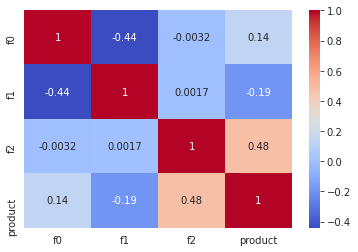

################################################ 
 location_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


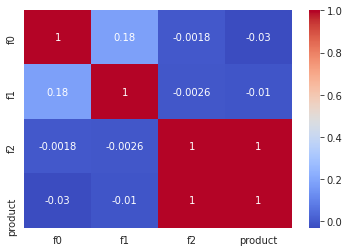

################################################ 
 location_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


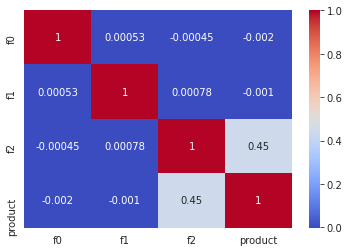

In [5]:
for i in location_dict:
    print('################################################ \n',i)
    display_info_corr(location_dict[i])

- Обнаружена слабая отрицательная корреляция между признаками f0 и f_1 в location_0.
- Обнаружена **очень сильная** (практически линейная) корреляция между f2 и целевым признаком в location_1
- Обнаружена слабая положительная корреляция между f2 и целевым признаком в location_2

### Проверка на дубликаты

In [6]:
for i in location_dict:
    print(f'Всего полных дубликатов по {i}: {location_dict[i].duplicated().sum()}')

Всего полных дубликатов по location_0: 0
Всего полных дубликатов по location_1: 0
Всего полных дубликатов по location_2: 0


Проверим на частичные дубликаты по `id`

In [7]:
for i in location_dict:
    print(i)
    display(location_dict[i][location_dict[i]['id'].duplicated(keep = False)].sort_values('id'))

location_0


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


location_1


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


location_2


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Данные содержат дубликаты по `id`, нам это не сильно важно, т.к. остальные признаки в дубликатах разнятся и это не повлияет на работу модели, но, тем не менее, стоит передать эту информацию заказчику, чтобы исключить возможные ошибки при работе с этими данными в дальнейшем

Отделим целевые признаки от нецелевых

In [8]:
def select_features_target(data):
    target = data['product']
    features = data.drop(['id','product'], axis = 1)
    return features, target

In [9]:
features_0, target_0 = select_features_target(geo_data_0)
features_1, target_1 = select_features_target(geo_data_1)
features_2, target_2 = select_features_target(geo_data_2)

Стандартизировать данные не будем, т.к. модель построим с 

**Выводы по разделу:**

- Определили формат данных:
    - `id` - индикаторы скважин, в работе моделей будут нам не нужны
    - `f0`, `f1`, `f2` - некие признаки
    - `product` - объем запасов в скважине в тыс.баррелей - наш целевой признак
- `id` не будет участвовать в работе модели, данные не нуждаются в кодировании
- Пропусков в данных не обнаружено
- Обнаружена слабая отрицательная корреляция между признаками f0 и f_1 в location_0
- Обнаружена **очень сильная** корреляция между f2 и целевым признаком в location_1 - предположительно, модель в этой геолокации даст наименьшую ошибку, но все равно проверим все локации.
- Обнаружена слабая положительная корреляция между f2 и целевым признаком в location_2
- Полные дубликаты не обнаружены
- Частичные дубликаты обнаружены только в колонке `id`, принято решение ничего не выбрасывать из данных, т.к. колонка `id` не нужна для работы модели
- Отделили целевые признаки от нецелевых

## Обучение и проверка модели

Необходимо обучить модель линейной регрессии, предсказывающую количество запасов по признакам `f0`, `f1`, `f2`

Для начала разделим выборки на `train` и `test`, обучим и применим скалер, затем обучим линейную регрессию и посмотрим метрики.
Напишем функцию, которая сохранит наши модели, скейлеры и выведет метрики.

Также функция сохранит предсказания модели для **всех данных**. Это понадобится в одном из следующих шагов

In [10]:
def best_location_choice(features, target):
    features_train, features_test, target_train, target_test = train_test_split(features, target, random_state = 12345)
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train[features_train.columns] = scaler.transform(features_train)
    features_test[features_test.columns] = scaler.transform(features_test)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    preds = model.predict(features_test)
    mse = mean_squared_error(target_test, preds)
    
    print('Средний объем сырья', preds.mean())
    print('MSE =', mse)
    print('RMSE =', mse ** 0.5)
    
    features_scaled = features.copy(deep = True)
    features_scaled[features_scaled.columns] = scaler.transform(features)
    all_preds = pd.Series(model.predict(features_scaled), name = 'product')
    
    return model, scaler, all_preds

In [11]:
model_0, scaler_0, all_preds_0 = best_location_choice(features_0, target_0)

Средний объем сырья 92.59256778438035
MSE = 1412.2129364399243
RMSE = 37.5794217150813


/tmp/ipykernel_48/1193854163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[features_train.columns] = scaler.transform(features_train)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Первая модель довольно сильно ошибается, предсказанный средний объем сырья 92.59 тыс. баррелей

In [12]:
model_1, scaler_1, all_preds_1 = best_location_choice(features_1, target_1)

Средний объем сырья 68.728546895446
MSE = 0.7976263360391157
RMSE = 0.893099286775617


/tmp/ipykernel_48/1193854163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[features_train.columns] = scaler.transform(features_train)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Вторая модель имеет гораздо меньшие значения метрик. Связано с высокой корреляцией `f2` с целевым признаком

средний предсказанный объем сырья 68.73 тыс. баррелей

In [13]:
model_2, scaler_2, all_preds_2 = best_location_choice(features_2, target_2)

Средний объем сырья 94.96504596800489
MSE = 1602.3775813236196
RMSE = 40.02970873393434


/tmp/ipykernel_48/1193854163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[features_train.columns] = scaler.transform(features_train)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Третья модель предсказывает хуже первой, но средний предсказанный объем сырья самый большой: 94.97 тыс.баррелей

**Итог по шагу 2:**
Построили модель для каждого из трех регионов:
- Модель первого региона предсказывает объем сырья в 92.59 т.б., но с большой ошибкой
- Вторая модель предсказывает меньший объем сырья (68.73 т.б.), но почти не ошибается
- Третья модель предсказывает объем сырья больше чем первая (94.97 т.б.), но и ошибка тоже больше

## Подготовка к расчёту прибыли

По условиям задачи:
- выделенный бюджет на разработку скважин составляет 10млрд рублей. Это наш капекс на исследование 500 скважин и бурения 200 скважин из этой выборки
- доход с каждой добытой тысячи баррелей составляет 450000 рублей (предполагаем, что под доходом имеется в виду операционная прибыль)

In [14]:
budget = 10000000000
wells_bored = 200
barrel_margin = 450000

Рассчитаем точку безубыточности

In [15]:
breakeven_point = budget / (wells_bored * barrel_margin)
breakeven_point

111.11111111111111

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b>
    
<b>Успех:</b><br>
👍 Достаточный объём сырья для безубыточной разработки новой скважины рассчитан верно.
</div>

**Вывод:**
По итогу, чтобы только выйти в ноль нам нужно чтобы средний объем сырья в пробуренных скважинах был равен 111.111 тыс баррелей.
Это меньше чем в `0`, `2` релионах и сильно меньше, чем в `1` регионе.
Таким образом, следующим шагом в нашей задаче должен стать контроль рисков:
- либо получаем сильно варьирующийся доход со скважин в `0` и `2` регионах, со средним показателем запасов выше чем в регионе `1`
- либо получаем предсказуемый доход со скважин в `1` регионе, но со средним показателем запасов в скважине меньше, чем в регионах `0` и `2`

Конечно же, мы не можем утверждать со 100% вероятностью, что средний объем сырья в 200 лучших из 500 разведанных скважин в регионе `1` будет меньше, чем в регионах `0` и `2`, т.к. мы еще не смотрели на наклон прямой нашей Линейной Регрессии и не оценивали распределение 200 лучших скважин.

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b><br>
    
Корректнее сравнивать объем для безубыточности со средним реальным запасом всего региона, т.е. с target_0.mean() и т.д.. <br>       

Здесь вот еще на что надо обратить внимание! <br> 

Средний объем предсказанного сырья рассчитан на основании 25 000 точек, из которых в результате надо выбрать 200. В результате,  среди этих скважин могут быть скважины с достаточным и недостаточным запасом сырья. <br>
    
Имеено техника "Bootstrap" позволяет оценить риск убытков при случайным отборе точек. 1000 раз отбирая случайным образом точки, считаем какой % случаев принесет убытки. 
    
   
</div>

## Расчёт прибыли и рисков 

Для начала напишем функцию, которая будет принимать на вход предсказанные значения (нам нужно отобрать 200 скважин с самой высокой выработкой) но считать прибыль по реальным значениям

Ранее мы сохранили предсказанные значения для всех данных. Их и будем использовать

In [16]:
def profit_calculating(preds, target):
    preds_sorted = preds.sort_values(ascending = False)
    selected = target[preds_sorted.index][:200]
    return selected.sum() * barrel_margin - budget

In [17]:
profit_calculating(all_preds_0, target_0)

3494104192.112015

In [18]:
profit_calculating(all_preds_1, target_1)

2415086696.681511

In [19]:
profit_calculating(all_preds_2, target_2)

2571410631.960928

Полученные цифры обозначают прибыль в случае, при котором мы бы выбрали по модели 200 лучших скважин из **уже существующих 100000**

Но мы будем разрабатывать другие скважины

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b><br>
    
Было бы здорово знать заранее 200 лучших скважин:)
</div>

Мы имеем данные по 100000 скважинам в каждом регионе. В каждом регионе имеем по 500 потенциальных точек для бурения новых скважин.

Признаки `f0`, `f1`, `f2` и, соответственно, предсказанные по ним значения 500 разведанных скважин для каждого региона будут иметь похожее распределение с уже пробуренными скважинами. Оценим это распределение с помощью техники бутстреп

Мы создадим 1000 выборок по 500 скважин в каждой. В каждом случае нам нужно выбрать 200 лучших из этих 500 и посчитать прибыль функцией `profit_calculating`

In [20]:
def bootstrap_wells_profit(target, predictions):
    state = np.random.RandomState(12345)
    
    profits = []
    for i in range(1000):
        target_sample = target.sample(n=500, replace = True, random_state = state)
        preds_sample = predictions[target_sample.index]
        profits.append(profit_calculating(preds_sample, target_sample))
    
    profit = pd.Series(profits)
    
    return profit

<div class="alert alert-block alert-success"><b>Комментарий ревьюера</b>
    
<b>Успех:</b><br>
    👍 Отлично, что при семплировании данных устанавливаешь `replace = True`, это необходимо чтобы наблюдение в выборку попало несколько раз, что позволяет добиться независимости при каждом выборе, иначе вероятность достать элемент из выборки будет с каждым разом увеличиваться. Чем больше размер подвыборки, тем выраженнее будет зависимость, поэтому без возврата не удастся получить разнообразные варианты, а подвыборку бОльшего размера вообще не получить.

Почему именно так. Вспомним, что выборка - это некоторое представление о генеральной совокупности, ее часть. Значит, что где-то в регионе существуют и другие потенциальные точки добычи нефти, о которых мы можем не знать, но они являются частью этой генеральной совокупности. В этом случае повторяющиеся наблюдения можно считать разными точками добычи из всей генеральной совокупности с близкими характеристиками.
    
</div>  

Посмотрим на получившиеся значения и визуализируем распределение прибыли по каждому региону

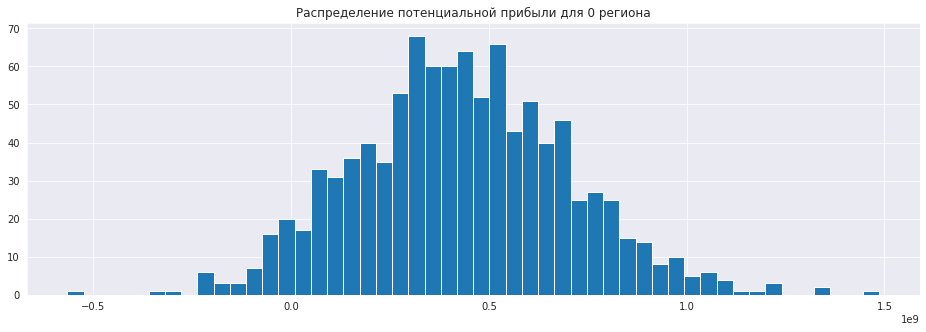

In [21]:
profit_0_reg = bootstrap_wells_profit(target_0, all_preds_0)
profit_0_reg.hist(bins = 50, figsize = (16,5))
plt.title('Распределение потенциальной прибыли для 0 региона')
plt.show()

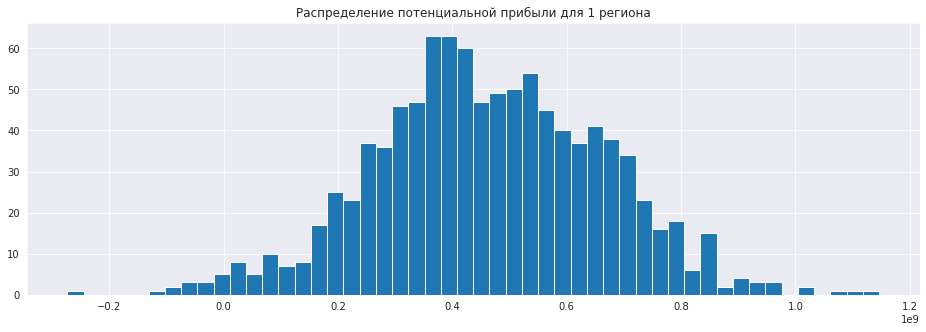

In [22]:
profit_1_reg = bootstrap_wells_profit(target_1, all_preds_1)
profit_1_reg.hist(bins = 50, figsize = (16,5))
plt.title('Распределение потенциальной прибыли для 1 региона')
plt.show()

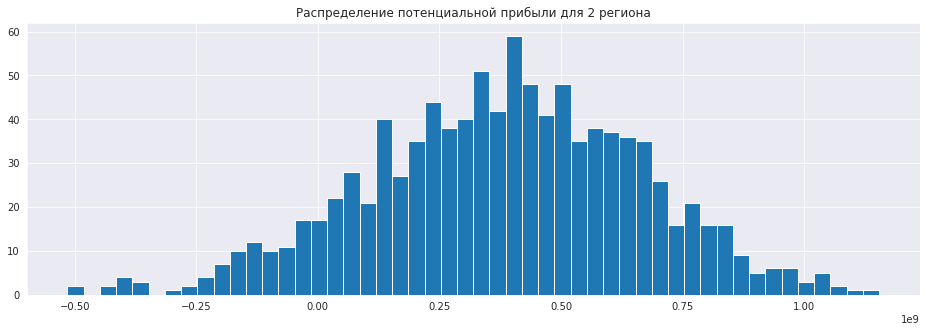

In [23]:
profit_2_reg = bootstrap_wells_profit(target_2, all_preds_2)
profit_2_reg.hist(bins = 50, figsize = (16,5))
plt.title('Распределение потенциальной прибыли для 2 региона')
plt.show()

Полученные значения отображают возможные прибыль и убытки для 1000 случайных ислледований 500 скважин и выбора 200 лучших

Найдем 95% доверительный интервал для этих распределений. таким образом мы отсечем регионы, в которых риск убытка будет больше 2.5%

In [24]:
def conf_interval(profit):
    upper = profit.quantile(0.975)
    lower = profit.quantile(0.025)
    print('Доверительный интервал:', lower.round(0), upper.round(0))
    count = 0
    for i in profit:
        if i < 0:
            count += 1
    print('Риск убытков:', count / len(profit))

In [25]:
conf_interval(profit_0_reg)

Доверительный интервал: -70541767.0 979019659.0
Риск убытков: 0.051


In [26]:
conf_interval(profit_1_reg)

Доверительный интервал: 55988530.0 845839331.0
Риск убытков: 0.013


In [27]:
conf_interval(profit_2_reg)

Доверительный интервал: -177060947.0 896985478.0
Риск убытков: 0.091


**Вывод:**

Для 0 региона прибыль с 95% вероятностью окажется в диапазоне от -71млн до 979 млн рублей. Риск убытков 5.1%

Для 1 региона прибыль с 95% вероятностью окажется в диапазоне от 56 до 845 млн рублей. Риск убытков 1.3%

Для 2 региона прибыль с 95% вероятностью окажется в диапазоне от -177 до 897 млн рублей. Риск убытков 9.1%

Из-за большой ошибки моделей для 0 и 2 регионов мы с большой вероятностью получили предсказания скважин, которые оказывлись далеко не лучшими

При неизменных вводных (бюджет и прибыль с единицы продукта) для разработки рекомендуется **1 регион**

<div class="alert alert-block alert-success"><b>Комментарий ревьюера</b>
    
<b>Успех:</b><br>
    👍 Выбор региона абсолютно верный!)
    
</div>  

## Общий вывод по проекту

Целью проекта являлось определение локации для бурения новых скважин

С помощью машинного обучения были построены модели для предсказания запасов в скважинах по трем регионам 

С помощью моделей были сделаны предсказания объема сырья для 500 случайных скважин(с применением рехнологии bootstrap) во всех регионах и отобраны 200 лучших.

Построены распределения прибылей для каждого региона
Посчитаны 95% доверительные интервалы для каждого региона
Посчитаны риски для каждого региона

Если бы модели 0 и 2 предсказывали лучше, то мы могли бы более тщательно отобрать 200 лучших скважин из предполагаемых 500 и, возможно, был бы определен другой регион для разработки

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>Общий вывод по проекту</u></b>
<font color='green'><br> 


Александр, приложено много усилий, ты - молодец! Крепкий проект! Критичных ошибок нет. Есть несколько важных моментов, которые я отметила и которые можно было бы улучшить, подсказки ты найдешь в моих комментариях. 

**Что мне особенно понравилось в твоей работе:**:
 
* Хорошее знакомство с данными.
* Рассчитан средний запас предсказанного сырья для каждого региона.
* Рассчитан достаточный объём сырья для безубыточной разработки новой скважины.    
* Написана функция для расчёта прибыли.
* Использованы функции для повторяющихся действий.    
* Рассчитаны риски, прибыль и доверительный интервал для каждого региона.   
* Есть выводы в каждом блоке.    
* Код логичный и понятный. 
* Проект полностью соответствует плану!<br>

Очень рекомендую посмотреть видео от Глеба Михайлова!)<br>
**[Линейная Регрессия для Дата Саентиста](https://www.youtube.com/watch?v=QZJ94igWVxQ&t=19s)**     <br> 
    
**[Вот здесь есть отличное объяснение с примером по мультиколлинеарности.](https://habr.com/ru/company/akbarsdigital/blog/592493/)** <br>
    
**[И здесь интересная статься - коротко о мультиколлинеарности и что с этим делать.](https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666)** <br>   
   
**[Еще очень рекомендую посмотреть короткие видео-лекции Карпова на степике](https://stepik.org/lesson/8095/step/1?unit=1371)**    <br>
    

😊Буду рада, если смогла быть тебе полезной!)<br> 
А я, в свою очередь, с удовольствием принимаю проект!<br> 
**И желаю тебе удачи в дальнейшей учебе!**😉

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован